# NHL MVP Analysis

This project is a first foray into machine learning. The goal is to predict player's vote share of the Hart trophy, which is awarded to the most valuable player in the National Hockey League as voted on by members of the Professional Hockey Writer's Association.  

Hockey statistics come from Evolving Hockey and Hockey-Reference. At the moment only basic statistics provided in the Hart trophy candidates by year summary page from Hockey-Reference are used. A medium term goal is to scrape data including advanced statistics to combine with the existing data. It is somewhat challenging to give an accurate prediction based only on the basic statistics used so far. In some cases it's really not the model's fault and vote share outliers are determined by factors beyond the basic statistics used so far (this could be things such as advanced statistics that we don't currently use, or things like narratives surrounding a team's season which a model trained on statistics will never be able to incorporate). The methodology used in this notebook is heavily inspired by Kaggle style projects. In particular, stacking base models using XGBoost is probably not the recommended way to structure one's first machine learning project, but it was fun. 

References/Acknowledgements:
Most of what appears in this notebook was learned/borrowed from Kaggle. In particular, two specific notebooks I heavily referenced are https://www.kaggle.com/arthurtok/introduction-to-ensembling-stacking-in-python and https://www.kaggle.com/mmueller/stacking-starter.

To do: 
    - fix double function definiton of get_base_predictions
    - add normalization pipeline

In [1]:
# imports
import numpy as np
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls
import warnings
import os

import xgboost as xgb

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import (RandomForestRegressor,  ExtraTreesRegressor)
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.model_selection import (KFold, train_test_split, GridSearchCV)
from sklearn.metrics import (mean_absolute_error)
from sklearn.pipeline import make_pipeline

from xgboost import XGBRegressor



warnings.filterwarnings('ignore')
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

%matplotlib inline
py.init_notebook_mode(connected=True)
pd.set_option('display.max_columns', 500)
os.environ['KMP_DUPLICATE_LIB_OK']='True'


In [2]:
%run webscrape.py

In [3]:
full_data= pd.read_csv("hockey-data-hart.csv")    

# clean it up
full_data=full_data.dropna(axis=0,subset=['pct_of_vote'])
full_data=full_data.drop(['first','second','third','fourth','fifth'],axis=1)
full_data = full_data[full_data["pct_of_vote"]>0]

# let's also drop goalies who are missing save pct, and skaters who are missing plus_minus
full_data = full_data.loc[~((full_data.pos=="G") & full_data.save_pct.isna())]
full_data = full_data.loc[~((full_data.pos!="G") & full_data.plus_minus.isna())]

# remaining na's should be due to mismatched position with stats. set them to zero
full_data = full_data.fillna(0)

# for non goalies (goalies), let's replace all goalie (non goalie) stats by zero rather than NaN

# Create a new feature p_simp: for players who have joint positions, we just keep the first one
def pos_combine(name):
    title_search = re.search('(^[A-Z]{1,2})', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""

full_data["pos"] = full_data["pos"].apply(pos_combine)

# add a new feature: geometric mean of goals and assists
# roughly speaking, this allows us to discriminate between
# two players whose total points are the same, but one is
# well balanced between goals and assists and the other is not

full_data["ga"] = np.sqrt(full_data["goals"]*full_data["assists"])




skaters = full_data[full_data['pos']!='G']
skaters['logpct_of_vote'] = np.log(skaters['pct_of_vote'])
goalies = full_data[full_data['pos']=='G']
goalies['logpct_of_vote'] = np.log(goalies['pct_of_vote'])
   
full_data.tail(5)

,Year,player,age,team_id,pos,votes,pct_of_vote,goals,assists,points,plus_minus,wins_goalie,losses_goalie,ties_goalie,goals_against_avg,save_pct,ops,dps,gps,ps,ga
1053,2018,Drew Doughty,28,Los Angeles Kings,D,3,0.18,10,50,60,23.0,0.0,0.0,0.0,0.0,0.0,4.4,7.3,0.0,11.7,22.360680
1054,2018,Patrice Bergeron,32,Boston Bruins,C,1,0.06,30,33,63,21.0,0.0,0.0,0.0,0.0,0.0,6.0,2.3,0.0,8.3,31.464265
1055,2018,Sidney Crosby,30,Pittsburgh Penguins,C,1,0.06,29,60,89,0.0,0.0,0.0,0.0,0.0,0.0,7.3,1.8,0.0,9.1,41.713307
1056,2018,Victor Hedman,27,Tampa Bay Lightning,D,1,0.06,17,46,63,32.0,0.0,0.0,0.0,0.0,0.0,5.7,5.2,0.0,11.0,27.964263
1057,2018,Eric Staal,33,Minnesota Wild,C,1,0.06,42,34,76,8.0,0.0,0.0,0.0,0.0,0.0,8.0,1.8,0.0,9.8,37.788887


              Year         age        votes  pct_of_vote       goals  \
count   919.000000  919.000000   919.000000   919.000000  919.000000   
mean   1994.758433   27.805223    86.720348    11.402818   26.317737   
std      16.189186    4.474344   209.790484    20.733008   19.411023   
min    1956.000000   18.000000     1.000000     0.060000    0.000000   
25%    1982.000000   25.000000     3.000000     0.495000    9.000000   
50%    1998.000000   27.000000    13.000000     1.970000   28.000000   
75%    2009.000000   31.000000    58.000000    10.840000   40.000000   
max    2018.000000   43.000000  1604.000000   100.000000   92.000000   

          assists      points  plus_minus  wins_goalie  losses_goalie  \
count  919.000000  919.000000  919.000000   919.000000     919.000000   
mean    40.129489   66.447225   15.565832     7.471164       4.194777   
std     26.820504   42.982405   20.033680    14.232928       8.312139   
min      0.000000    0.000000  -62.000000     0.000000     

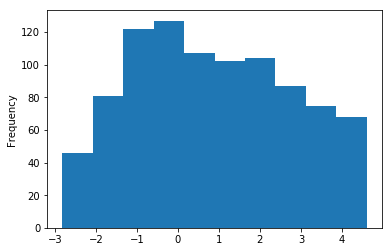

In [4]:
print(full_data.describe())
np.log(full_data['pct_of_vote']).plot.hist()

<Figure size 432x288 with 0 Axes>

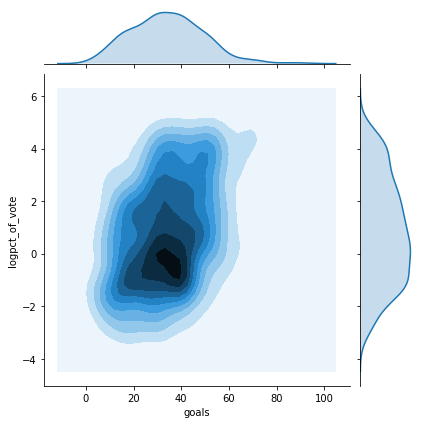

In [5]:
fig = plt.figure()
g = sns.jointplot(x='goals',y='logpct_of_vote',data = skaters, kind='kde', gridsize=40)

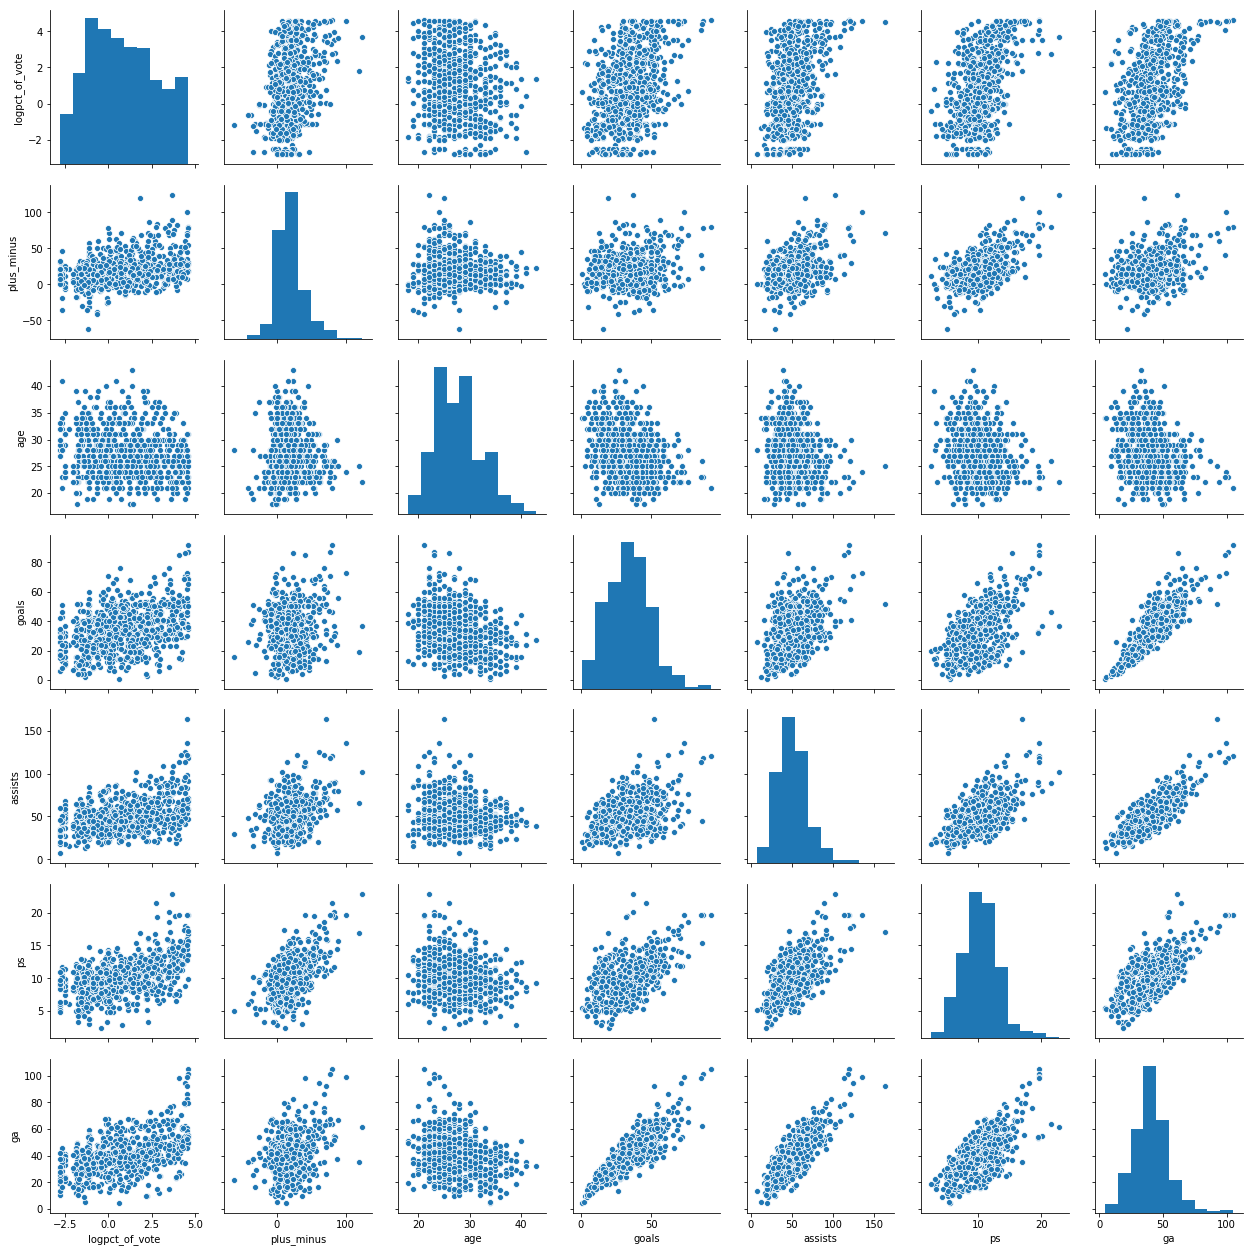

In [6]:
# examining some skater data
sns.pairplot(skaters[['logpct_of_vote','plus_minus','age','goals', 'assists','ps','ga']])

#### Let's see what brute force dimensionality reduction can show us

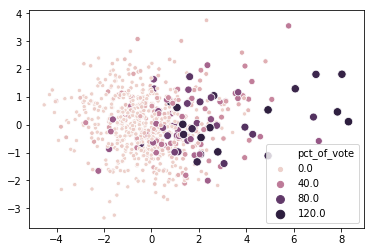

In [7]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
reduce = PCA(n_components=2)
scaler = StandardScaler()
x_scaled = scaler.fit_transform(skaters[['plus_minus','age','goals', 'assists','ps','ga']])
x_reduced = reduce.fit_transform(x_scaled)
hue = skaters['pct_of_vote']

sns.scatterplot(x = x_reduced[:,0],y = x_reduced[:,1],hue = hue,size=hue)

#### $z_1$ has strong correlation with vote share, $z_2$ appears to have almost no correlation. 

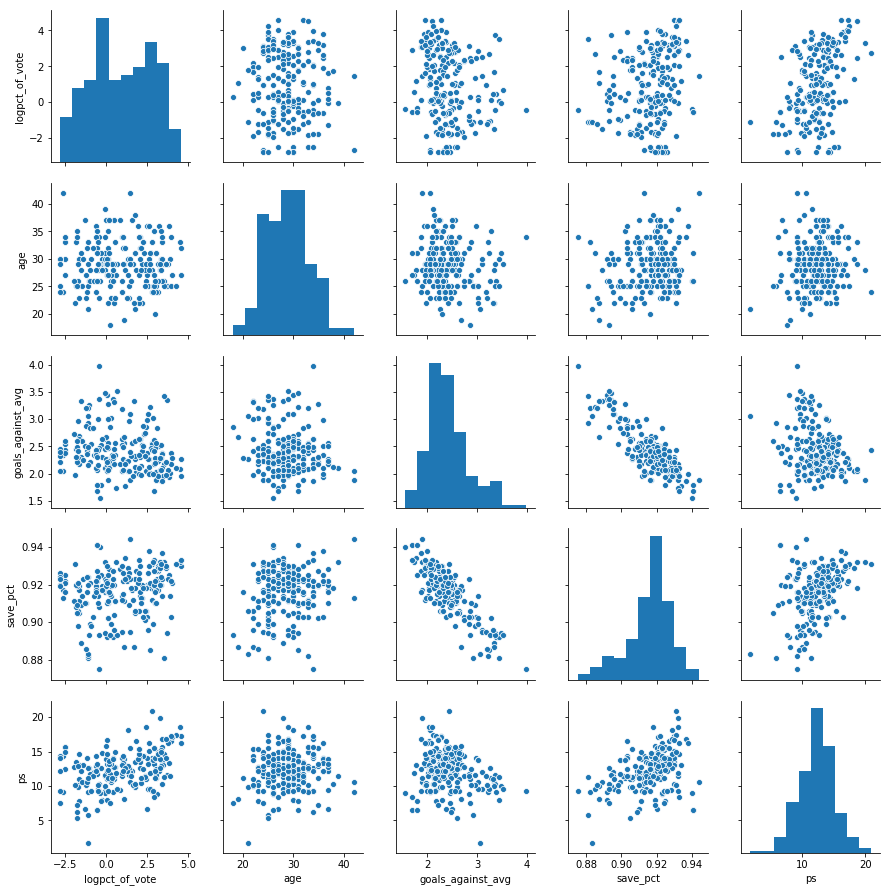

In [8]:
# examining some goalie data
sns.pairplot(goalies[['logpct_of_vote','age','goals_against_avg','save_pct','ps']])

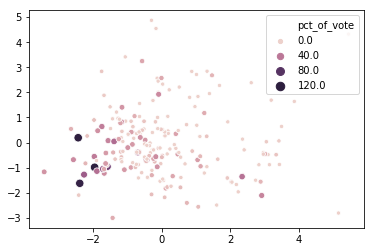

In [9]:
reduce = PCA(n_components=2)
scaler = StandardScaler()
x_scaled = scaler.fit_transform(goalies[['age','goals_against_avg','save_pct','ps','wins_goalie','losses_goalie','ties_goalie']])
x_reduced = reduce.fit_transform(x_scaled)
hue = goalies['pct_of_vote']

sns.scatterplot(x = x_reduced[:,0],y = x_reduced[:,1],hue = hue,size=hue)

#### There really are not enough goalies with high vote share to be confident about anything. But the 4-5 that do all have small values of $z_1$ and $z_2$. 

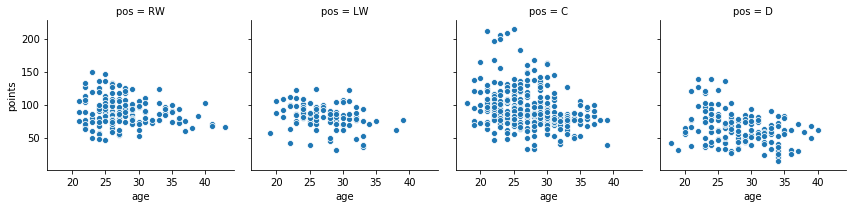

In [10]:
g = sns.FacetGrid(skaters,col="pos")
g.map(sns.scatterplot, 'age','points')

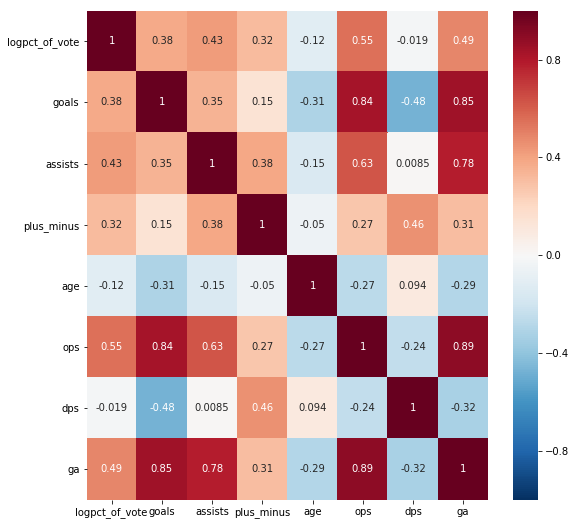

In [11]:
fd = skaters
features= ['logpct_of_vote','goals','assists','plus_minus','age','ops','dps','pos','ga']
fd = fd[features]
f = fd.corr()
plt.figure(figsize=(len(features),len(features)))

sns.heatmap(f,annot=True,cmap="RdBu_r",vmin=-1,vmax=1);

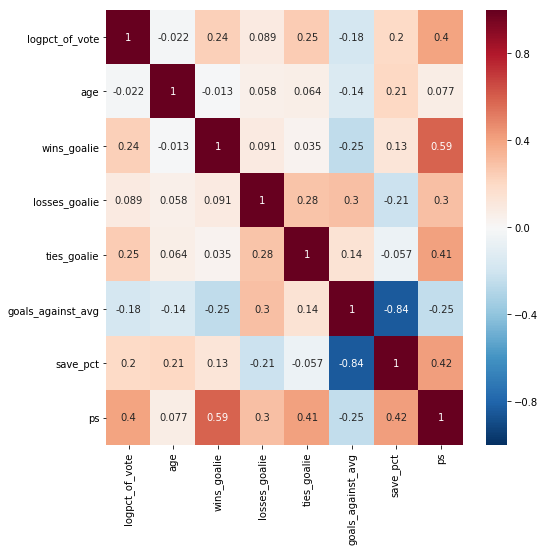

In [12]:
fd = goalies
features= ['logpct_of_vote','age','wins_goalie','losses_goalie',
           'ties_goalie','goals_against_avg','save_pct','ps']
fd = fd[features]
f = fd.corr()
plt.figure(figsize=(len(features),len(features)));

sns.heatmap(f,annot=True,cmap="RdBu_r",vmin=-1,vmax=1);

We can expect from the plots above that fitting a model to the available data might be challenging.

# Holdout Blend Approach

In [162]:
fd = full_data.copy()
# prepare for applying model:
# 1) preprocessing-scale
t = fd.drop(["Year",'pct_of_vote'],axis=1).select_dtypes(exclude=["object"]).apply(sklearn.preprocessing.scale)
fd[t.columns] = t
# this results in data contamination but for now let's just work with it


# 2) one-hot encode positions
fd=pd.get_dummies(fd,columns=['pos'])

fd[fd["Year"]==2018]
# full_data.sample(10)
# fd.pct_of_vote.plot.hist()


,Year,player,age,team_id,votes,pct_of_vote,goals,assists,points,plus_minus,wins_goalie,losses_goalie,ties_goalie,goals_against_avg,save_pct,ops,dps,gps,ps,ga,pos_C,pos_D,pos_G,pos_LW,pos_RW
1038,2018,Taylor Hall,-0.403681,New Jersey Devils,5.614748,77.07,0.653709,0.517442,0.618096,-0.078203,-0.525207,-0.504932,-0.496922,-0.532798,-0.542486,0.983580,0.148064,-0.525280,0.484855,0.686636,0,0,0,1,0
1039,2018,Nathan MacKinnon,-1.298153,Colorado Avalanche,5.280900,72.80,0.653709,0.666663,0.711208,-0.228032,-0.525207,-0.504932,-0.496922,-0.532798,-0.542486,1.008418,0.095303,-0.525280,0.484855,0.765832,1,0,0,0,0
1040,2018,Anze Kopitar,0.490792,Los Angeles Kings,2.214268,33.60,0.447529,0.629358,0.594818,0.271399,-0.525207,-0.504932,-0.496922,-0.532798,-0.542486,0.486831,0.570153,-0.525280,0.081978,0.628484,1,0,0,0,0
1041,2018,Claude Giroux,0.490792,Philadelphia Flyers,2.190422,33.29,0.395984,1.039715,0.827598,0.621001,-0.525207,-0.504932,-0.496922,-0.532798,-0.542486,0.760043,0.411870,-0.525280,0.350563,0.790633,1,0,0,0,0
1042,2018,Connor McDavid,-1.521771,Edmonton Oilers,0.874108,16.46,0.756800,1.002410,0.967266,0.221456,-0.525207,-0.504932,-0.496922,-0.532798,-0.542486,1.132605,0.306348,-0.525280,0.787012,0.995989,1,0,0,0,0
1043,2018,Nikita Kucherov,-0.850917,Tampa Bay Lightning,0.378105,10.12,0.653709,0.778579,0.781042,-0.028259,-0.525207,-0.504932,-0.496922,-0.532798,-0.542486,0.958743,-0.115742,-0.525280,0.283417,0.823450,0,0,0,0,1
1044,2018,Evgeni Malkin,0.714410,Pittsburgh Penguins,0.049026,5.91,0.808345,0.592053,0.734486,0.021684,-0.525207,-0.504932,-0.496922,-0.532798,-0.542486,1.058093,0.095303,-0.525280,0.552001,0.810282,1,0,0,0,0
1045,2018,Blake Wheeler,0.714410,Winnipeg Jets,-0.084513,4.21,-0.171013,1.039715,0.571540,-0.128146,-0.525207,-0.504932,-0.496922,-0.532798,-0.542486,0.288131,0.042542,-0.525280,-0.522337,0.385677,0,0,0,0,1
1046,2018,Alex Ovechkin,0.938028,Washington Capitals,-0.237129,2.26,1.169161,-0.079441,0.478428,-0.627577,-0.525207,-0.504932,-0.496922,-0.532798,-0.542486,0.834555,-0.062980,-0.525280,0.149124,0.556632,0,0,0,1,0
1047,2018,William Karlsson,-0.627299,Vegas Golden Knights,-0.260975,1.95,0.859890,-0.191357,0.268926,1.669807,-0.525207,-0.504932,-0.496922,-0.532798,-0.542486,0.586181,0.781198,-0.525280,0.350563,0.349948,1,0,0,0,0


In [163]:


model_features = [ u'age', u'goals', u'assists',  u'plus_minus',
       u'wins_goalie', u'losses_goalie', u'ties_goalie', u'goals_against_avg',
       u'save_pct', u'ps', u'pos_G', u'ga']

# Use all years 2015 and prior for training, and try to predict the previous three years.
target_yr = 2015
train=fd[fd["Year"]<=target_yr]
test=fd[fd["Year"] > target_yr]


# Prepare a holdout of the train set to use for blending. 
base, cv = train_test_split(train,test_size=0.1)

x_test = test[model_features]
y_test = test.pct_of_vote

x_base = base[model_features]
y_base = base.pct_of_vote

x_cv = cv[model_features]
y_cv = cv.pct_of_vote


# x_base and y_base will be used to fit the base models
# then make predictions for y_holdout using x_holdout
# those predictions are used to train the stacker




# # scaling preprocessing the data. I'm not sure if it's actually a good idea to do this
# # Leave it out for now.

# t = x_base.drop(["pos_G"],axis=1).select_dtypes(exclude=["object"]).apply(sklearn.preprocessing.scale)
# x_base[t.columns] = t

# t = x_holdout.drop(["pos_G"],axis=1).select_dtypes(exclude=["object"]).apply(sklearn.preprocessing.scale)
# x_holdout[t.columns] = t

# t = x_test.drop(["pos_G"],axis=1).select_dtypes(exclude=["object"]).apply(sklearn.preprocessing.scale)
# x_test[t.columns] = t

In [164]:
# Wrapper class for sklearn models
# It trains on logarithmically renormalized vote_pct, rather than raw.
# This is because heuristically the vote share by player
# in any given year is approximately exponentially decaying
# so it made sense to me to try to make the data more regular by taking the log.
class SklearnWrapper(object):
    def __init__(self,clf,seed=0,params=None):
        if hasattr(clf,'random_state'):
            params['random_state'] = seed
            
        self.clf = clf(**params)
        
    def __str__(self):
        return str(type(self.clf))
        
    # automatically does log conversion in train and predict
    def train(self,x_train,y_train):
        self.clf.fit(x_train,y_train)
        
    def predict(self,x):
        return self.clf.predict(x)
    
    def feature_importances(self):
        print(clf.feature_importances_)
        
    
        
def get_base_predictions(clf):
    clf.train(x_base,y_base)
    return clf.predict(x_cv)
    
# Wrapper for xgboost from sklearn courtesy of https://www.kaggle.com/mmueller/stacking-starter
class XgbWrapper(object):
    def __init__(self, seed=0, params=None):
        self.param = params
        self.param['seed'] = seed
        self.nrounds = params.pop('nrounds', 250)

    def train(self, x_train, y_train):
        dtrain = xgb.DMatrix(x_train, label=np.log(y_train))
        self.gbdt = xgb.train(self.param, dtrain, self.nrounds)

    def predict(self, x):
        return np.exp(self.gbdt.predict(xgb.DMatrix(x)))
        



In [165]:
#Try several models

# Put in our parameters. For now these values are the same as those in 
# https://www.kaggle.com/arthurtok/introduction-to-ensembling-stacking-in-python

# Random Forest parameters
et_params = {
    'n_jobs': -1,
    'n_estimators': 100,
    'max_features': 0.5,
    'max_depth': 6,
    'min_samples_leaf': 2,
}

rf_params = {
    'n_jobs': -1,
    'n_estimators': 100,
    'max_features': 0.6,
    'max_depth': 6,
    'min_samples_leaf': 2,
}


# Gradient Boosting parameters
gb_params = {
    'n_estimators': 100,
     'max_features': 0.2,
    'max_depth': 4,
    'min_samples_leaf': 2,
    'verbose': 0
}



mlp_params = {
    'hidden_layer_sizes': (10,10,6),
    'alpha': 0.5
}

linear_params = {
}
#honestly let's just keep default parameters for SVR
svr_params = {'C' : 2}

SEED = 0



forest = SklearnWrapper(clf=RandomForestRegressor,seed=SEED,params=rf_params)
# print("Forest Regressor MAE on training data: %f"% mean_absolute_error(forest.predict(x_holdout),y_holdout))

gbm = SklearnWrapper(clf=XGBRegressor,seed=SEED,params=gb_params)
# print("XGBRegressor MAE on training data: %f"% mean_absolute_error(gbm.predict(x_holdout),y_holdout))

mlp = SklearnWrapper(clf=MLPRegressor,seed=SEED,params=mlp_params)
# print("MLPRegressor MAE on training data: %f"% mean_absolute_error(mlp.predict(x_holdout),y_holdout))

et = SklearnWrapper(clf=ExtraTreesRegressor,seed=SEED,params=et_params)
# print("Extra Trees Regressor MAE on training data: %f"% mean_absolute_error(et.predict(x_holdout),y_holdout))

svr = SklearnWrapper(clf=SVR,seed=SEED,params=svr_params)

linear = SklearnWrapper(clf=LinearRegression,seed=SEED,params=linear_params)

          rf        gbm         et       mlp       svr        lin
0  19.030886  22.492664  11.728741  0.675723  3.927665  14.371064
1   7.163341  11.736551   8.892273  0.675723  3.803179  14.233730
2   6.908923   3.124874   9.105671  0.675723  6.504596  12.238662
3   6.139830   4.387720   7.492432  0.675723  2.221746  13.111878
4   5.794818   3.014648   7.727481  0.675723  2.338237  14.991526
5   2.993746   1.946886   3.433683  0.669549  0.754527 -13.179082
6   6.808298   4.483486   6.997530  0.675723  2.420564   7.464630
7  30.108278  32.765987  21.301051  0.675723  8.159155  20.140052
8   7.352129   7.662874   7.830402  0.675723  3.020344  10.294993
9   5.570721   6.676898   6.975716  0.675723  2.160798   9.951755


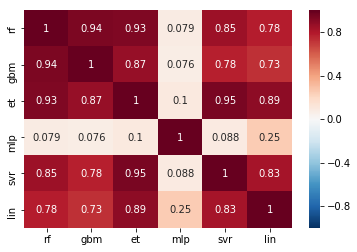

In [166]:
# use XGBoost to blend the base models
    
cv_predictions = pd.DataFrame({})

cv_predictions["rf"] = get_base_predictions(forest)
cv_predictions["gbm"] = get_base_predictions(gbm)
cv_predictions["et"] = get_base_predictions(et)
cv_predictions["mlp"] = get_base_predictions(mlp)
cv_predictions["svr"] = get_base_predictions(svr)
cv_predictions["lin"] = get_base_predictions(linear)
# cv_predictions["truth"] = np.array(y_cv)


# look at correlation map of base predictions
plt.figure()
z = cv_predictions.corr()
sns.heatmap(z,annot=True,cmap="RdBu_r",vmin=-1,vmax=1);


# the models are decently correlated with each other. 
# SVR is providing some diversity, although that might be
# because it is just not performing well. 

# add back in the original features. so we have basically added 5 meta features
# cv_predictions[model_features] = x_cv[model_features].reset_index(drop=True)

print(cv_predictions.head(10))
# cv_predictions = cv_predictions.drop(columns=['svr'])


#### SVR gives complete nonsense if the data is not scaled beforehand

In [167]:
# train the ensemble 
xgb_params = {
    'seed': 0,
    'colsample_bytree': 0.7,
    'silent': 1,
    'subsample': 0.7,
    'learning_rate': 0.2,
    'max_depth': 4,
    'num_parallel_tree': 1,
    'min_child_weight': 1,
    'eval_metric': 'mae',
    'nrounds': 150,
    'lambda': 0.2
}



stack = XgbWrapper(seed=SEED,params=xgb_params)


stack.train(cv_predictions,y_cv)
print("Averaged train MAE of stack %f" % mean_absolute_error(stack.predict(cv_predictions),y_cv))
print("Averaged CV MAE of rf %f" % mean_absolute_error(forest.predict(x_cv),y_cv))
print("Averaged CV MAE of et %f" % mean_absolute_error(et.predict(x_cv),y_cv))
print("Averaged CV MAE of mlp %f" % mean_absolute_error(mlp.predict(x_cv),y_cv))
print("Averaged CV MAE of gbm %f" % mean_absolute_error(gbm.predict(x_cv),y_cv))
print("Averaged CV MAE of svr %f" % mean_absolute_error(svr.predict(x_cv),y_cv))
print("Averaged CV MAE of linear %f" % mean_absolute_error(linear.predict(x_cv),y_cv))


# out of curiosity, what if we just fit another linear regression to the base model predictions
linear_combine = LinearRegression()
linear_combine.fit(cv_predictions,y_cv)
print("Averaged train MAE of linear combination %f" % mean_absolute_error(linear_combine.predict(cv_predictions),y_cv))

Averaged train MAE of stack 0.047022
Averaged CV MAE of rf 9.055549
Averaged CV MAE of et 9.650959
Averaged CV MAE of mlp 7.971382
Averaged CV MAE of gbm 9.463281
Averaged CV MAE of svr 7.301113
Averaged CV MAE of linear 11.701515
Averaged train MAE of linear combination 7.775935


There just is not enough data in the cv set, xgboost just memorizes the whole thing if you let it run for long enough. I expect that if we use a kfold approach on the whole training set for xgboost stacking as well we can solve or at least mitigate the high variance this method suffers from. Another option is to just hamstring XGBoost by limiting it to a small number of rounds. This should improve performance on the test set.

Average test MAE of stack 11.260439
Average test MAE of linear combination 11.431650
Test MAE of mean of base predictions 11.394742


<Figure size 432x288 with 0 Axes>

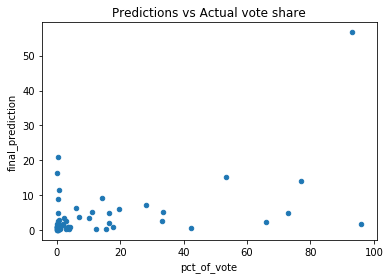

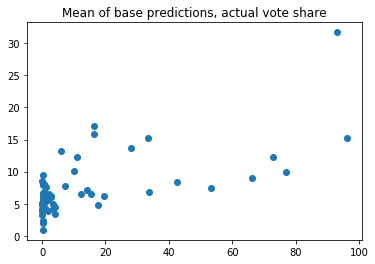

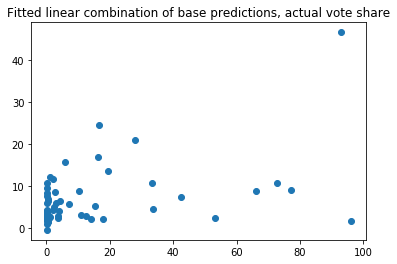

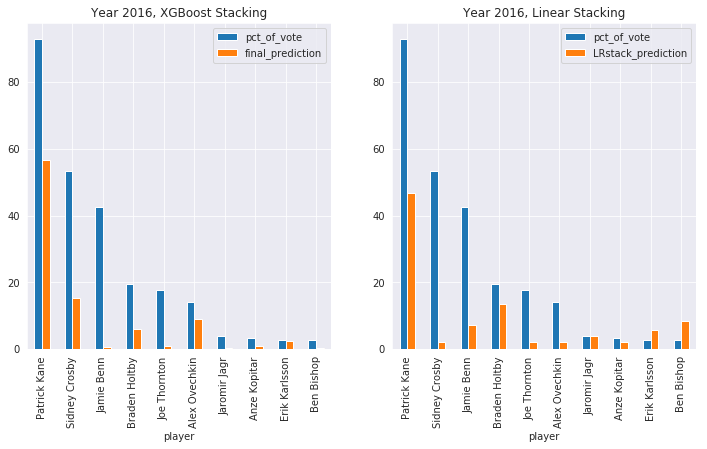

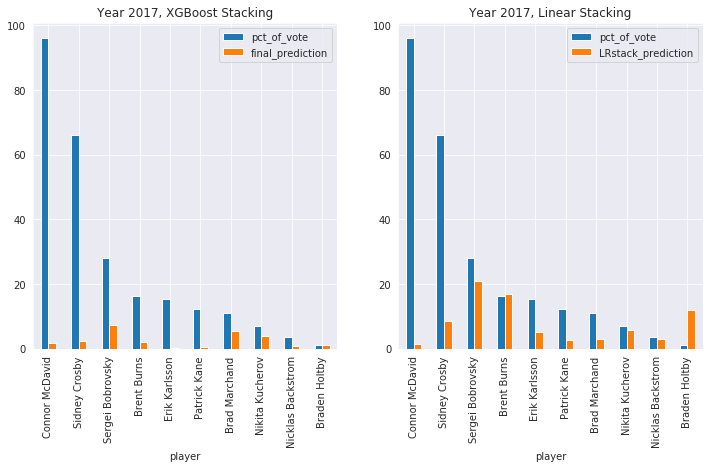

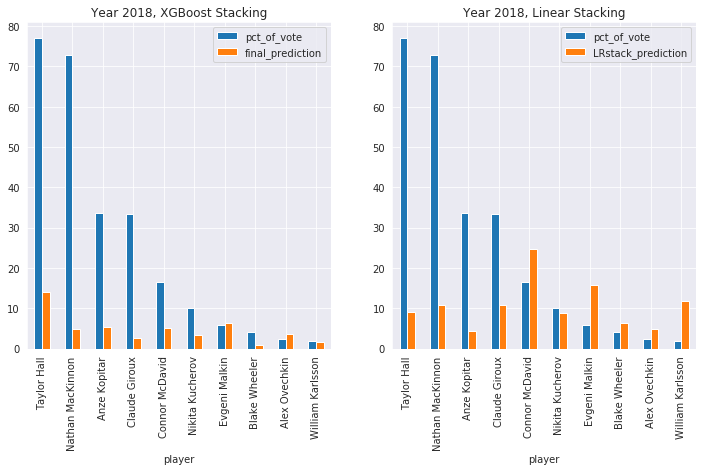

In [168]:
# feature importances, out of curiosity
# print zip(lvl1_predictions.columns,stack.feature_importances)


# prepare input predictions for blender
x_test_lvl2 = pd.DataFrame(columns = {})

x_test_lvl2["rf"] = forest.predict(x_test)
x_test_lvl2["gbm"] = gbm.predict(x_test)
x_test_lvl2["et"] = et.predict(x_test)
x_test_lvl2["mlp"] = mlp.predict(x_test)
x_test_lvl2["svr"] = svr.predict(x_test)
x_test_lvl2["lin"] = linear.predict(x_test)
# x_test_lvl2[model_features] = x_test[model_features].reset_index(drop=True)

linear_preds = linear_combine.predict(x_test_lvl2)

test["final_prediction"] = stack.predict(x_test_lvl2)
test["LRstack_prediction"] = linear_preds

fig = plt.figure()
test.plot.scatter(x='pct_of_vote',y='final_prediction')
plt.title('Predictions vs Actual vote share')

plt.figure()
plt.scatter(test['pct_of_vote'],x_test_lvl2.mean(axis=1))
plt.title('Mean of base predictions, actual vote share')

plt.figure()
plt.scatter(test['pct_of_vote'],linear_combine.predict(x_test_lvl2))
plt.title('Fitted linear combination of base predictions, actual vote share')
# g = sns.FacetGrid(test,col="Year",height=6,orientation="h")
# g.map(sns.barplot, 'player','pct_of_vote')
# sns.catplot(x='player', y = 'pct_of_vote',data=test,kind='bar',row='Year',sharex=False,height=14)


# its annoyingly difficult to make a facetgrid to show the three years
with sns.axes_style("darkgrid"):
    for year in [2016,2017,2018]:
        t = test[test['Year']==year]
        fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(12,6))
        
        t[['player','pct_of_vote','final_prediction']].head(10).plot.bar(x='player',ax=axes[0])
        axes[0].set_title("Year %i, XGBoost Stacking" % year)
        
        t[['player','pct_of_vote','LRstack_prediction']].head(10).plot.bar(x='player',ax=axes[1])
        axes[1].set_title("Year %i, Linear Stacking" % year)
    

print("Average test MAE of stack %f" % mean_absolute_error(test["final_prediction"],y_test))
print("Average test MAE of linear combination %f" % mean_absolute_error(linear_preds,y_test))

# at least xgboost does do better than a simple linear combination, that would 
# have been pretty demoralizing

# let's check one more thing, a straightforward averaging of the results
print("Test MAE of mean of base predictions %f" % mean_absolute_error(x_test_lvl2.mean(axis=1),y_test))

# well that's demoralizing. 


# out of all of the methods, linear regression on the base models honestly looks the most reasonable.

Some years, such as 2018, are particularly unkind. After a brief investigation, our model seems to strongly overweigh goals, which is not an unreasonable thing to do. The model just sees the statistics in a vacuum, and has no idea about the team's record during that year, or advanced statistics such as WAR that more directly quantify how useful a player was to their team. So there is clearly room for improvement here. Case in point, in 2018 Connor McDavid literally had higher everything than Taylor hall. Why did Taylor Hall crush McDavid in the voting? Part of the answer is probably that the Oilers were terrible in 2018, not even making the playoffs. As for the rest, only the hockey gods can say. One final comment is that the performance of this model seems to vary quite a bit with random train/holdout splits. It's also embarassing that a simple linear combination of the base predictions performs better than XGBoost but that's the curse of small sample size.

In [151]:
idx1 = (test.player=="Connor McDavid") & (test.Year == 2018)
idx2 = (test.player=="Taylor Hall") & (test.Year == 2018)
idx3 = (test.player=="Nathan MacKinnon") & (test.Year == 2018)
test[idx1 | idx2 | idx3]


,Year,player,age,team_id,votes,pct_of_vote,goals,assists,points,plus_minus,wins_goalie,losses_goalie,ties_goalie,goals_against_avg,save_pct,ops,dps,gps,ps,ga,pos_C,pos_D,pos_G,pos_LW,pos_RW,final_prediction,LRstack_prediction
1038,2018,Taylor Hall,26,New Jersey Devils,1264,77.07,39,54,93,14.0,0.0,0.0,0.0,0.0,0.0,9.9,2.3,0.0,12.2,45.891176,0,0,0,1,0,1.922112,14.160422
1039,2018,Nathan MacKinnon,22,Colorado Avalanche,1194,72.80,39,58,97,11.0,0.0,0.0,0.0,0.0,0.0,10.0,2.2,0.0,12.2,47.560488,1,0,0,0,0,14.179365,12.334613
1042,2018,Connor McDavid,21,Edmonton Oilers,270,16.46,41,67,108,20.0,0.0,0.0,0.0,0.0,0.0,10.5,2.6,0.0,13.1,52.411831,1,0,0,0,0,22.464764,22.321417


Trying again with kfold approach rather than 10% holdout from training set

# KFold CV, Hyperparameter optimization, stack training

In [169]:
fd = full_data.copy()
fd=pd.get_dummies(fd,columns=['pos'])
from sklearn.preprocessing import StandardScaler

model_features = [ u'age', u'goals', u'assists',  u'plus_minus',
       u'wins_goalie', u'losses_goalie', u'ties_goalie', u'goals_against_avg',
       u'save_pct', u'ps', u'pos_G', u'ga']

target_yr = 2015

train = fd[fd["Year"] <= target_yr]
test = fd[fd["Year"] > target_yr]

# train,test = train_test_split(fd,test_size=0.25)


X_train, X_test = train[model_features], test[model_features]
y_train, y_test = train["pct_of_vote"], test["pct_of_vote"]

# normalize the data
scaler = StandardScaler()
scaler.fit(X_train) # fit only to the training data. it's kind of annoying
# that we rescale the binary variable pos_G but i guess it doesn't matter

X_train[model_features] = scaler.transform(X_train[model_features])
X_test[model_features] = scaler.transform(X_test[model_features])



ntrain = train.shape[0]
ntest = test.shape[0]
nfolds = 8

def get_base_predictions(clf):

    clf.train(X_train,y_train)
    return clf.predict(X_test)

In [170]:
kf = KFold(n_splits=nfolds,shuffle=True)

In [171]:
def get_oof_predictions(clf,X_train,y_train,X_test):
    infold_train = np.zeros((ntrain,))
    infold_train_byfold = np.zeros((nfolds,ntrain))
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_byfold = np.zeros((nfolds,ntest))
    
    for i, (train_idx, cv_idx) in enumerate(kf.split(X_train)):
        x_tr = X_train.iloc[train_idx]
        x_cv = X_train.iloc[cv_idx]
        y_tr = y_train.iloc[train_idx]
        
        clf.train(x_tr,y_tr)
        
        # use n-1 fold to make prediction for i'th fold 
        oof_train[cv_idx] = clf.predict(x_cv)
        infold_train_byfold[i,train_idx] = clf.predict(x_tr)
        
        # also make predictions for the test data. since
        # we have nfolds different models trained on the different
        # fold combinations, we can just average them together to 
        # get their prediction on the test set
        oof_test_byfold[i,:] = clf.predict(X_test)
    
    oof_test[:] = oof_test_byfold.mean(axis=0)
    infold_train[:] = infold_train_byfold.mean(axis=0)*nfolds/(nfolds-1) #because we
    # actually only have nfolds-1 predictions for a given fold
    
    return infold_train.reshape(-1,1), oof_train.reshape(-1,1), oof_test.reshape(-1,1)

    


In [173]:
for clf in [forest, et, gbm, mlp,linear,svr]:
    oof = get_oof_predictions(clf,X_train,y_train,X_test)
    print("Train error of %s: %.2f" % (clf,mean_absolute_error(oof[0],y_train)))
    print("OOF (CV) error of %s: %.2f" % (clf,mean_absolute_error(oof[1],y_train)))
    print("Test error of %s: %.2f \n" % (clf,mean_absolute_error(oof[2],y_test)))

Train error of <class 'sklearn.ensemble.forest.RandomForestRegressor'>: 7.34
OOF (CV) error of <class 'sklearn.ensemble.forest.RandomForestRegressor'>: 9.58
Test error of <class 'sklearn.ensemble.forest.RandomForestRegressor'>: 11.37 

Train error of <class 'sklearn.ensemble.forest.ExtraTreesRegressor'>: 9.48
OOF (CV) error of <class 'sklearn.ensemble.forest.ExtraTreesRegressor'>: 10.37
Test error of <class 'sklearn.ensemble.forest.ExtraTreesRegressor'>: 12.51 

Train error of <class 'xgboost.sklearn.XGBRegressor'>: 5.02
OOF (CV) error of <class 'xgboost.sklearn.XGBRegressor'>: 10.01
Test error of <class 'xgboost.sklearn.XGBRegressor'>: 10.95 

Train error of <class 'sklearn.neural_network.multilayer_perceptron.MLPRegressor'>: 9.87
OOF (CV) error of <class 'sklearn.neural_network.multilayer_perceptron.MLPRegressor'>: 10.17
Test error of <class 'sklearn.neural_network.multilayer_perceptron.MLPRegressor'>: 11.70 

Train error of <class 'sklearn.linear_model.base.LinearRegression'>: 12.01

That's a fairly reasonable result. The random forest, extra trees, and MLP are generalizing well. XGBRegressor is suffering from high variance (although it's performance on CV and test data is still in line with the other models), and MLP might be suffering from slightly high bias. All of these models can stand to be improved by doing a hyperparameter grid search. But let's see what we can accomplish by stacking these models with XGBoost with a larger training data.

In [175]:
meta_train = pd.DataFrame()
meta_test = pd.DataFrame()

# meta_train[model_features] = X_train[model_features].reset_index(drop=True)
# meta_test[model_features] = X_test[model_features].reset_index(drop=True)


for (name,clf) in [("rf",forest), ("et",et), ("gbm",gbm), ("mlp",mlp),("lin",linear),("svr",svr)]:
    infold_train, oof_train, oof_test = get_oof_predictions(clf,X_train,y_train,X_test)
    meta_train[name] = np.squeeze(oof_train)
    meta_test[name] = get_base_predictions(clf)
    


In [176]:
#just out of curiosity, a general look at how our base models are doing
pd.concat([meta_train,y_train.reset_index(drop=True)],axis=1).sample(10)

,rf,et,gbm,mlp,lin,svr,pct_of_vote
9,6.786753,9.773427,8.676209,12.748111,15.952630,4.174732,29.27
411,44.946841,41.456624,65.514687,52.948890,39.269573,23.770781,28.89
752,5.231155,8.230995,4.437055,9.285931,13.261715,3.504375,0.24
161,5.123143,8.130759,5.126845,7.253824,9.238019,1.827599,3.49
437,15.110735,18.642727,12.376490,14.962099,20.587839,7.426769,12.22
526,4.813916,4.675699,7.012550,0.931457,-5.357407,1.100539,2.10
177,22.893598,23.030170,36.481041,29.345518,26.628229,16.990270,18.30
388,32.198428,23.818138,18.221684,30.361740,26.018018,13.564088,71.85
10,4.929228,7.759343,7.044658,9.676840,7.370312,4.594360,24.74
658,10.757422,12.532837,10.717075,18.131669,17.668423,5.218474,11.72


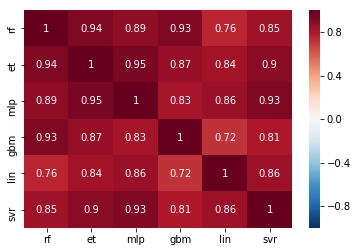

In [177]:
# correlation of base models
plt.figure()
z = meta_train[['rf','et','mlp','gbm','lin','svr']].corr()
sns.heatmap(z,annot=True,cmap="RdBu_r",vmin=-1,vmax=1);

In [178]:
# now train the stack, again using kfold with the same folds for cross validation
# perhaps it would be a better idea to use the base version of XGBRegressor provided
# by sklearn rather than the advanced interface

# xgb_params = {
#     'seed': 0,
#     'colsample_bytree': 0.2,
#     'silent': 1,
#     'subsample': 0.3,
#     'learning_rate': 0.3,
#     'max_depth': 2,
#     'num_parallel_tree': 30,
#     'min_child_weight': 0.7,
#     'eval_metric': 'mae',
#     'nrounds': 25,
#     'lambda': 1
# }

# stack = XgbWrapper(seed=SEED,params=xgb_params)

# This takes some time to run
model = XGBRegressor()

parms = {'nthread':[1], #when use hyperthread, xgboost may become slower
              'objective':['reg:linear'],
              'learning_rate': [0.3,0.1,.03, 0.05], #so called `eta` value
              'max_depth': [3,4,5],
              'min_child_weight': [3,4,5],
              'silent': [1],
              'subsample': [0.5,0.7,0.9],
              'colsample_bytree': [0.1,0.3,0.5],
              'n_estimators': range(20,120,20),
              'reg_lambda': [0.5,0.8,1]}


grid_search = GridSearchCV(model,parms,cv=kf)
grid_result = grid_search.fit(meta_train,y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))



Best: 0.414220 using {'colsample_bytree': 0.5, 'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 60, 'nthread': 1, 'objective': 'reg:linear', 'reg_lambda': 1, 'silent': 1, 'subsample': 0.5}


In [190]:
# let's just hard save them so that we don't have to rerun the above 
# every time 
best_params = {'colsample_bytree': 0.5, 
               'learning_rate': 0.05, 
               'max_depth': 3, 
               'min_child_weight': 3, 
               'n_estimators': 60, 
               'nthread': 1, 
               'objective': 'reg:linear', 
               'reg_lambda': 1, 
               'silent': 1, 
               'subsample': 0.5}

In [191]:
stack = SklearnWrapper(clf=XGBRegressor,params=best_params,seed=SEED)

oof = get_oof_predictions(stack,meta_train,y_train,meta_test)
print("Train error of stack %.2f" % mean_absolute_error(oof[0],y_train))
print("OOF error of stack %.2f" % mean_absolute_error(oof[1],y_train))
print("Test error of stack %.2f" % mean_absolute_error(oof[2],y_test))

Train error of stack 8.31
OOF error of stack 9.57
Test error of stack 11.29


<Figure size 432x288 with 0 Axes>

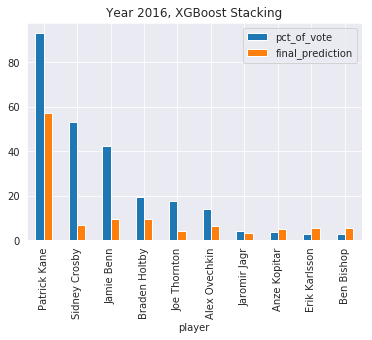

<Figure size 432x288 with 0 Axes>

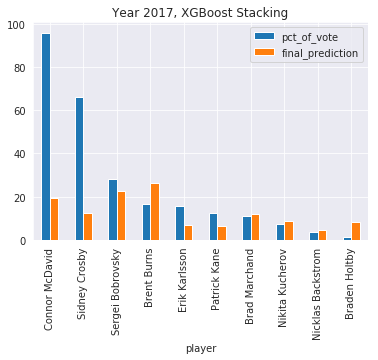

<Figure size 432x288 with 0 Axes>

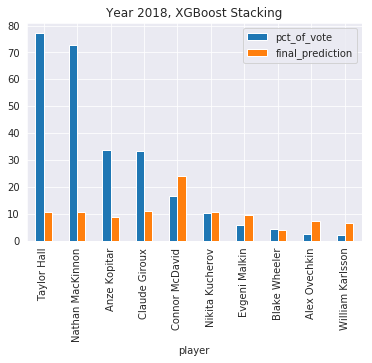

In [192]:
test["final_prediction"] = oof[2]
with sns.axes_style("darkgrid"):
    for year in [2016,2017,2018]:
        t = test[test['Year']==year]
        plt.figure()
        
        t[['player','pct_of_vote','final_prediction']].head(10).plot.bar(x='player')
        plt.title("Year %i, XGBoost Stacking" % year)

#### Well unfortunately we have not really done much better here. Try linear regression again.

Train error of linear 9.53
OOF error of linear 9.69
Test error of linear 11.48


<Figure size 432x288 with 0 Axes>

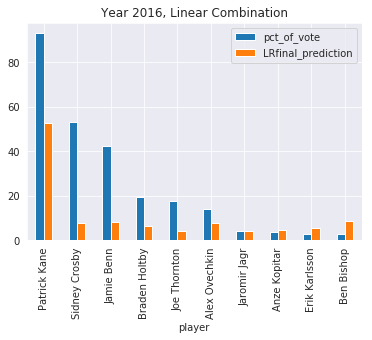

<Figure size 432x288 with 0 Axes>

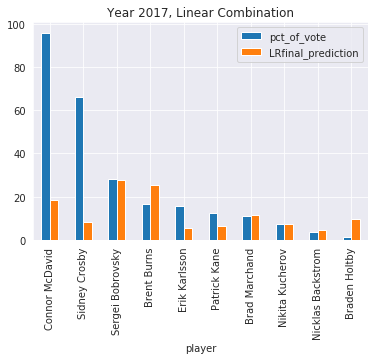

<Figure size 432x288 with 0 Axes>

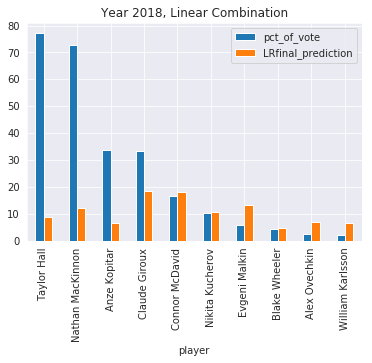

In [193]:
linear_stack = SklearnWrapper(clf=LinearRegression,params={})

oof = get_oof_predictions(linear_stack,meta_train,y_train,meta_test)
print("Train error of linear %.2f" % mean_absolute_error(oof[0],y_train))
print("OOF error of linear %.2f" % mean_absolute_error(oof[1],y_train))
print("Test error of linear %.2f" % mean_absolute_error(oof[2],y_test))

test["LRfinal_prediction"] = oof[2]
with sns.axes_style("darkgrid"):
    for year in [2016,2017,2018]:
        t = test[test['Year']==year]
        plt.figure()
        
        t[['player','pct_of_vote','LRfinal_prediction']].head(10).plot.bar(x='player')
        plt.title("Year %i, Linear Combination" % year)

# Predictions for 2019
With the Playoffs upon us, it is time to make predictions for the 2019 Hart trophy winner. (It's probably Nikita Kucherov)

In [203]:
df = pd.read_csv("2019-data.csv")
# now we need to prepare these into the same format as what we trained on
model_features

['age',
 'goals',
 'assists',
 'plus_minus',
 'wins_goalie',
 'losses_goalie',
 'ties_goalie',
 'goals_against_avg',
 'save_pct',
 'ps',
 'pos_G',
 'ga']

In [204]:
# clean it up

# because of formatting of 2019 website, there are "headers" inserted every 20 or so lines,
#which we want to remove
df = df[df["player"]!='Player']


# because skater and goalie data is pulled from individual pages, the goalie
# page does not list a positon. So they end up with NA in our scraped file
posfill = {"pos" : "G"}
df=df.fillna(value=posfill)

#  na's should be due to mismatched position with stats. set them to zero
df = df.fillna(0)

# df["pos"] = df["pos"].apply(pos_combine)

numeric_columns = ['age', 'goals', 'assists', 'points',
       'plus_minus', 'wins_goalie', 'losses_goalie', 'ties_goalie',
       'goals_against_avg', 'save_pct', 'ops', 'dps', 'gps', 'ps']

for col in numeric_columns:
    df[col] = df[col].apply(pd.to_numeric) 

In [205]:
# add a new feature: geometric mean of goals and assists
# roughly speaking, this allows us to discriminate between
# two players whose total points are the same, but one is
# well balanced between goals and assists and the other is not

df["ga"] = np.sqrt(df["goals"]*df["assists"])


In [206]:
df.describe()

,age,goals,assists,points,plus_minus,wins_goalie,losses_goalie,ties_goalie,goals_against_avg,save_pct,ops,dps,gps,ps,ga
count,1183.000000,1183.000000,1183.000000,1183.000000,1183.000000,1183.000000,1183.000000,1183.000000,1183.000000,1183.000000,1183.0,1183.0,1183.000000,1183.000000,1183.000000
mean,26.322063,6.956044,11.642434,18.598478,-0.691462,1.107354,0.901944,0.239222,0.288056,0.081106,0.0,0.0,0.387743,2.091716,8.437111
std,4.124777,9.123783,13.722650,21.711270,9.255372,4.873299,3.667508,1.071591,0.954284,0.257509,0.0,0.0,1.693746,2.686899,10.474784
min,18.000000,0.000000,0.000000,0.000000,-41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,-0.400000,-1.100000,0.000000
25%,23.000000,0.000000,1.000000,2.000000,-5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000
50%,26.000000,3.000000,6.000000,11.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,1.000000,4.582576
75%,29.000000,10.000000,18.000000,28.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,3.300000,12.845233
max,42.000000,51.000000,87.000000,128.000000,39.000000,39.000000,28.000000,10.000000,7.000000,0.947000,0.0,0.0,12.500000,14.600000,59.724367


In [207]:
# alright, looks like we're in okay shape. 
df = pd.get_dummies(df,columns=['pos'])

# apply normalization
df[model_features] = scaler.transform(df[model_features])

data = pd.DataFrame()
for (name,clf) in [("rf",forest), ("et",et), ("gbm",gbm), ("mlp",mlp),("lin",linear),("svr",svr)]:
    data[name] = clf.predict(df[model_features])

In [208]:
data.sample(5)

,rf,et,gbm,mlp,lin,svr
478,3.036756,2.957289,2.345895,6.076437,-17.598026,1.388032
952,3.098826,3.358862,2.156975,6.774060,-28.070688,3.002198
410,4.319342,3.430876,2.312715,6.106810,-28.519727,2.515368
200,3.239934,3.144187,4.120600,5.401165,-22.401950,3.206637
225,2.945049,3.229768,2.345895,6.110840,-27.952854,2.281516


In [209]:
xgboost_pred = stack.predict(data)
lr_pred = linear_stack.predict(data)

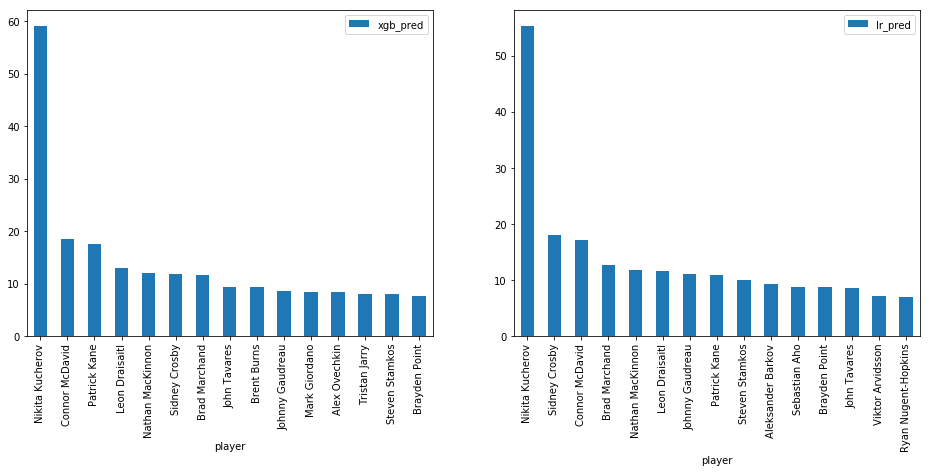

In [210]:
df["xgb_pred"] = xgboost_pred
df["lr_pred"] = lr_pred
fig,axes = plt.subplots(1,2,figsize=(16,6))
df_sorted_xgb = df.sort_values(by='xgb_pred',ascending=False)
df_sorted_xgb.head(15).plot.bar(y='xgb_pred',x='player',ax=axes[0])
df_sorted_lr = df.sort_values(by='lr_pred',ascending=False)
df_sorted_lr.head(15).plot.bar(y='lr_pred',x='player',ax=axes[1])

## And there we have it. Nikita Kucherov is our undisputed winner. In all likelihood he will win with vote share close to 80 or 90% than 50% shown here. All of our models are scared of large numbers, and really hesistate to predict a large vote share.